In [1]:
import numpy as np
import pandas as pd

In [2]:

df = pd.read_csv('native_data/polyadb_processed_v3.csv', delimiter=',')
df = df.query("site_type == '3_most_exon'").copy().reset_index(drop=True)
#df = df.loc[~df['wide_seq_ext'].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAA|AAAGAAAA|AAACAAAA|AAAAGAAA|AAAACAAA")].copy().reset_index(drop=True)

isoform_df = pd.read_csv("native_data/polyadb_processed_v3_utr3_isoforms_and_coords.csv", sep='\t')
isoform_df = isoform_df.rename(columns={'seq' : 'iso_seq'})

df = df.loc[df['gene_id'].isin(isoform_df['gene_id'].values.tolist())].copy().reset_index(drop=True)
df = df.join(isoform_df[['gene_id', 'iso_seq']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

'''
#Apply isoform sequence quality filters
df.loc[df['iso_seq'].isnull(), 'iso_seq'] = 'MISSING'

df['iso_seq_len'] = df['iso_seq'].str.len()
df['iso_seq_missing'] = df['iso_seq'].apply(lambda x: 1 if x == 'MISSING' else 0)

df['iso_seq_end'] = df['iso_seq'].apply(lambda x: x[-35:-5])
df['iso_seq_valid'] = df.apply(lambda row: 1 if row['iso_seq_end'] in row['wide_seq_ext'][175-40:175-40+146] else 0, axis=1)

df = df.query("iso_seq != 'MISSING' and iso_seq_len >= 32 and iso_seq_len <= 12288 and iso_seq_valid == 1").copy().reset_index(drop=True)
'''

print(df)


          gene    gene_id  sitenum  num_sites  pas  \
0      AADACL3  AADACL3.2        2          2    0   
1        ABCA4    ABCA4.1        5          5    0   
2       ABCB10   ABCB10.6        2          7    0   
3       ABCB10   ABCB10.5        3          7    0   
4       ABCB10   ABCB10.4        4          7    2   
5       ABCB10   ABCB10.3        5          7    0   
6       ABCB10   ABCB10.2        6          7    0   
7       ABCB10   ABCB10.1        7          7    0   
8        ABCD3    ABCD3.6        6         15    3   
9        ABCD3    ABCD3.7        7         15    0   
10       ABCD3    ABCD3.8        8         15    2   
11       ABCD3    ABCD3.9        9         15    4   
12       ABCD3   ABCD3.10       10         15    4   
13       ABCD3   ABCD3.11       11         15    2   
14       ABCD3   ABCD3.12       12         15    3   
15       ABCD3   ABCD3.13       13         15    0   
16       ABCD3   ABCD3.14       14         15    0   
17       ABCD3   ABCD3.15   

In [3]:

#Make Valid PAS lookup hierarchy

cano_pas1 = 'AATAAA'
cano_pas2 = 'ATTAAA'

valid_pas = []

valid_pas.append({})
valid_pas[0]['AATAAA'] = True

valid_pas.append({})
valid_pas[1]['ATTAAA'] = True

valid_pas.append({})
valid_pas[2]['AGTAAA'] = True
valid_pas[2]['TATAAA'] = True
valid_pas[2]['CATAAA'] = True
valid_pas[2]['GATAAA'] = True

valid_pas.append({})
for pos in range(0, 6) :
    for base in ['A', 'C', 'G', 'T'] :
        valid_pas[3][cano_pas1[:pos] + base + cano_pas1[pos+1:]] = True

valid_pas.append({})
for pos1 in range(0, 6) :
    for pos2 in range(pos1 + 1, 6) :
        for base1 in ['A', 'C', 'G', 'T'] :
            for base2 in ['A', 'C', 'G', 'T'] :
                valid_pas[4][cano_pas1[:pos1] + base1 + cano_pas1[pos1+1:pos2] + base2 + cano_pas1[pos2+1:]] = True


In [4]:
#Global dataframe generation

gene_dict_pas_4 = {}
gene_dict_pas_3 = {}
gene_dict_pas_2 = {}
gene_dict_pas_1 = {}

for index, row in df.iterrows() :
    gene = row['gene']
    found_pas = row['pas']
    
    if gene not in gene_dict_pas_4 :
        gene_dict_pas_4[gene] = 0
    
    if gene not in gene_dict_pas_3 :
        gene_dict_pas_3[gene] = 0
    
    if gene not in gene_dict_pas_2 :
        gene_dict_pas_2[gene] = 0
    
    if gene not in gene_dict_pas_1 :
        gene_dict_pas_1[gene] = 0
    
    if found_pas != -1 and found_pas <= 4 :
        gene_dict_pas_4[gene] += 1
    if found_pas != -1 and found_pas <= 3 :
        gene_dict_pas_3[gene] += 1
    if found_pas != -1 and found_pas <= 2 :
        gene_dict_pas_2[gene] += 1
    if found_pas != -1 and found_pas <= 1 :
        gene_dict_pas_1[gene] += 1

prox_sitenum_pas_4 = []
prox_sitenum_pas_3 = []
prox_sitenum_pas_2 = []
prox_sitenum_pas_1 = []
num_sites_pas_4 = []
num_sites_pas_3 = []
num_sites_pas_2 = []
num_sites_pas_1 = []

gene_next_dict_pas_4 = {}
gene_next_dict_pas_3 = {}
gene_next_dict_pas_2 = {}
gene_next_dict_pas_1 = {}

for index, row in df.iterrows() :
    
    gene = row['gene']
    
    if gene not in gene_next_dict_pas_4 :
        gene_next_dict_pas_4[gene] = -1
    
    if gene not in gene_next_dict_pas_3 :
        gene_next_dict_pas_3[gene] = -1
    
    if gene not in gene_next_dict_pas_2 :
        gene_next_dict_pas_2[gene] = -1
    
    if gene not in gene_next_dict_pas_1 :
        gene_next_dict_pas_1[gene] = -1
    
    found_pas = row['pas']
    
    if found_pas != -1 and found_pas <= 4 :
        gene_next_dict_pas_4[gene] += 1
    if found_pas != -1 and found_pas <= 3 :
        gene_next_dict_pas_3[gene] += 1
    if found_pas != -1 and found_pas <= 2 :
        gene_next_dict_pas_2[gene] += 1
    if found_pas != -1 and found_pas <= 1 :
        gene_next_dict_pas_1[gene] += 1
    
    sitenum_pas_4 = -1
    if found_pas != -1 and found_pas <= 4 :
        sitenum_pas_4 = gene_next_dict_pas_4[gene]
    
    sitenum_pas_3 = -1
    if found_pas != -1 and found_pas <= 3 :
        sitenum_pas_3 = gene_next_dict_pas_3[gene]
    
    sitenum_pas_2 = -1
    if found_pas != -1 and found_pas <= 2 :
        sitenum_pas_2 = gene_next_dict_pas_2[gene]
    
    sitenum_pas_1 = -1
    if found_pas != -1 and found_pas <= 1 :
        sitenum_pas_1 = gene_next_dict_pas_1[gene]
    
    prox_sitenum_pas_4.append(sitenum_pas_4 + (1 if sitenum_pas_4 != -1 else 0))
    prox_sitenum_pas_3.append(sitenum_pas_3 + (1 if sitenum_pas_3 != -1 else 0))
    prox_sitenum_pas_2.append(sitenum_pas_2 + (1 if sitenum_pas_2 != -1 else 0))
    prox_sitenum_pas_1.append(sitenum_pas_1 + (1 if sitenum_pas_1 != -1 else 0))
    
    num_sites_pas_4.append(gene_dict_pas_4[gene])
    num_sites_pas_3.append(gene_dict_pas_3[gene])
    num_sites_pas_2.append(gene_dict_pas_2[gene])
    num_sites_pas_1.append(gene_dict_pas_1[gene])
    
df['sitenum_pas_4'] = prox_sitenum_pas_4
df['sitenum_pas_3'] = prox_sitenum_pas_3
df['sitenum_pas_2'] = prox_sitenum_pas_2
df['sitenum_pas_1'] = prox_sitenum_pas_1

df['num_sites_pas_4'] = num_sites_pas_4
df['num_sites_pas_3'] = num_sites_pas_3
df['num_sites_pas_2'] = num_sites_pas_2
df['num_sites_pas_1'] = num_sites_pas_1
'''
df = df[['gene',
        'gene_id',
        'sitenum',
        'num_sites',
        'sitenum_pas_4',
        'num_sites_pas_4',
        'sitenum_pas_3',
        'num_sites_pas_3',
        'sitenum_pas_2',
        'num_sites_pas_2',
        'sitenum_pas_1',
        'num_sites_pas_1',
        'pas',
        'seq',
        'pas_pos',
        'cut_mode',
        'chrom',
        'strand']]
'''
df = df.sort_values(by=['chrom', 'gene', 'sitenum']).copy().reset_index(drop=True)

print(df.head())
print(df.tail())

print('Total number of members: ' + str(len(df)))


      gene    gene_id  sitenum  num_sites  pas  \
0  AADACL3  AADACL3.2        2          2    0   
1    ABCA4    ABCA4.1        5          5    0   
2   ABCB10   ABCB10.6        2          7    0   
3   ABCB10   ABCB10.5        3          7    0   
4   ABCB10   ABCB10.4        4          7    2   

                                                 seq  \
0  GCTGCAGGTGGTGGTTGCTGAAGGTGGGGGAGGCTGTGGCAATTTC...   
1  TTTCTGCATGTTTGTCTGTGTGTCTGCGTTGTGTGTGATTTTCATG...   
2  GTTAAAGATTGAAGCTATTGTCAAATGACAACTTTAAAAAGGCAAT...   
3  CTATTTCATGAAAAGCATGGAATATTATATTTTATTGTTCATAATT...   
4  CATAATTAATGAATAAAATTGATATGAATGAATATAGTGTTCTTTG...   

                                             seq_ext  \
0  TAAATTGTCGTAATCTTTTTGCTGGTTGATGGTCTTGCCTTGATGT...   
1  CCACTAGCAGCTTTGGCCTCCATATTGCTCTCATTTCAAGCAGATC...   
2  TGGAATATTTTAATTAATATAGCATGGCACCTCATTTTCTTTTGCC...   
3  CATGAACTAAGCATTTATTAGTTCCCTGATTAGACTGGAAGAAGAA...   
4  AGAAGAAACCACTATTTCATGAAAAGCATGGAATATTATATTTTAT...   

                         

In [5]:
df

,gene,gene_id,sitenum,num_sites,pas,seq,seq_ext,wide_seq,wide_seq_ext,pas_pos,...,rpm,iso_seq,sitenum_pas_4,sitenum_pas_3,sitenum_pas_2,sitenum_pas_1,num_sites_pas_4,num_sites_pas_3,num_sites_pas_2,num_sites_pas_1
0,AADACL3,AADACL3.2,2,2,0,GCTGCAGGTGGTGGTTGCTGAAGGTGGGGGAGGCTGTGGCAATTTC...,TAAATTGTCGTAATCTTTTTGCTGGTTGATGGTCTTGCCTTGATGT...,TGTATGTTACATTCATGGGAATGTCTAAATTGTCGTAATCTTTTTG...,TGCGTGGGTTTTCTCTGAGTTCTCCAGCTTCCTCCCACATTCCAAA...,12788705,...,3.328937,TGACCATCTTTCTTCTCTGCTGGTACTGCGGTGTGGATTCCACTGG...,1,1,1,1,1,1,1,1
1,ABCA4,ABCA4.1,5,5,0,TTTCTGCATGTTTGTCTGTGTGTCTGCGTTGTGTGTGATTTTCATG...,CCACTAGCAGCTTTGGCCTCCATATTGCTCTCATTTCAAGCAGATC...,CCAGAACTAGAAACCCCGGGCCATCCCACTAGCAGCTTTGGCCTCC...,TGGAACACCTGATGGTGAAACCAAACAAATACAAAATCCTTCTCCA...,94458420,...,0.877850,TGATCTTTCACACCGCTCGTTCCTGCAGCCAGAAAGGAACTCTGGG...,1,1,1,1,1,1,1,1
2,ABCB10,ABCB10.6,2,7,0,GTTAAAGATTGAAGCTATTGTCAAATGACAACTTTAAAAAGGCAAT...,TGGAATATTTTAATTAATATAGCATGGCACCTCATTTTCTTTTGCC...,TCAGGTTTTGTATTTTCTTTTCTTGTGGAATATTTTAATTAATATA...,GAGTTTTAATAATTGTAACTTTTTAAATGTCTATAGCACTGAAGTT...,229653571,...,0.984183,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,1,1,1,1,6,6,6,5
3,ABCB10,ABCB10.5,3,7,0,CTATTTCATGAAAAGCATGGAATATTATATTTTATTGTTCATAATT...,CATGAACTAAGCATTTATTAGTTCCCTGATTAGACTGGAAGAAGAA...,AATGTAAATCAAATGGAAGTTTTCCCATGAACTAAGCATTTATTAG...,AAGTGCTTTTTCTCCATGGATGAGGCTAGACCCTAAGAAGTAATTA...,229652609,...,1.306171,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,2,2,2,2,6,6,6,5
4,ABCB10,ABCB10.4,4,7,2,CATAATTAATGAATAAAATTGATATGAATGAATATAGTGTTCTTTG...,AGAAGAAACCACTATTTCATGAAAAGCATGGAATATTATATTTTAT...,TTATTAGTTCCCTGATTAGACTGGAAGAAGAAACCACTATTTCATG...,GTAATTAAGTCAATGTAAATCAAATGGAAGTTTTCCCATGAACTAA...,229652570,...,1.047152,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,3,3,3,-1,6,6,6,5
5,ABCB10,ABCB10.3,5,7,0,TCTGATACATGATGTTCAATTTTATCTTTAGGTAATATTTTATATC...,TGTGCCATAGAAGTATTTACGAAATTGCATTTCATTGTTATGTTTT...,GGTTGAATCTGAGGAAAATAATCCTTGTGCCATAGAAGTATTTACG...,TGTGTTCTTTATAAAGTGTGATTTTCAGAAAGCAAACAACACAATT...,229652351,...,2.855958,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,4,4,4,3,6,6,6,5
6,ABCB10,ABCB10.2,6,7,0,AACTTCTCACTACATTGTTTCTTAGTAGAATTTGGCTGTGGAGATT...,TTTTTTTTTATGACCCAGGAACCAAAGATGCAGTCTGTCATTTCTT...,AACTTTATCTGTGTCTGTCACTTTTTTTTTTTTTATGACCCAGGAA...,CAATTTTATCTTTAGGTAATATTTTATATCATAGATTAAAATTTAT...,229652210,...,0.786950,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,5,5,5,4,6,6,6,5
7,ABCB10,ABCB10.1,7,7,0,TCAGGAATAAAGAAAAGACTAACATTACACATATCCAAAAACATGT...,TATAAAACTTCTCACTACATTGTTTCTTAGTAGAATTTGGCTGTGG...,ACCAAAGATGCAGTCTGTCATTTCTTATAAAACTTCTCACTACATT...,TAGTGAACTTTATCTGTGTCTGTCACTTTTTTTTTTTTTATGACCC...,229652165,...,0.823096,TAAGGAAGCAATTACTGGTAAACAATATGAGACTTTAATGCAAAAC...,6,6,6,5,6,6,6,5
8,ABCD3,ABCD3.6,6,15,3,CATTTAATATTATATAGGATATTGCTAATTGTGTATATGTTGGTTT...,AAAGCAACAAATTAACTAGATACAGAATAATGGAGAACAAGTTGTT...,CTTAGTTTTTTTTAAAAAAAAAAACAAAGCAACAAATTAACTAGAT...,ATTACAGAATATACTTAGAAAGGCAAAGTACATTGTAAAATAAAGT...,94982896,...,0.942836,TAGAGAAATCTGGAGAACTATACCTGCTTCAGTGAAATAATTACAG...,1,1,-1,-1,10,8,6,4
9,ABCD3,ABCD3.7,7,15,0,ATAATATGTACTAAGAATGTCCTTATTCTTGTGGTTAAAAACCTGC...,ATTTAATATTATATAGGATATTGCTAATTGTGTATATGTTGGTTTA...,ATAATGGAGAACAAGTTGTTAAAACATTTAATATTATATAGGATAT...,TTAGTTTTTTTTAAAAAAAAAAACAAAGCAACAAATTAACTAGATA...,94982947,...,1.032161,TAGAGAAATCTGGAGAACTATACCTGCTTCAGTGAAATAATTACAG...,2,2,1,1,10,8,6,4


In [6]:

df.to_csv('polyadb_processed_utr3_isoforms.csv', header=True, index=False, sep='\t')


In [6]:

df = pd.read_csv('polyadb_processed_utr3_isoforms.csv', sep='\t')


n genes (total) = 12639


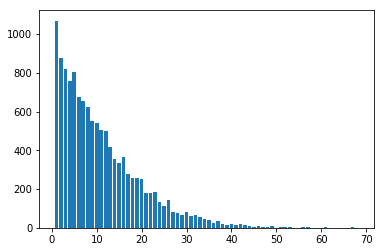

n genes (total) = 11099


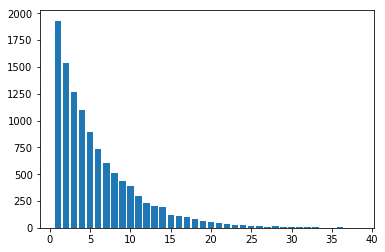

n genes (total) = 10418


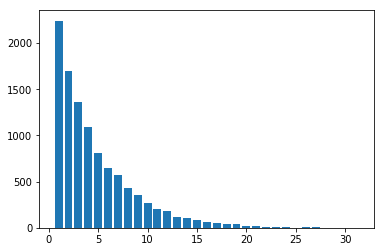

n genes (total) = 9561


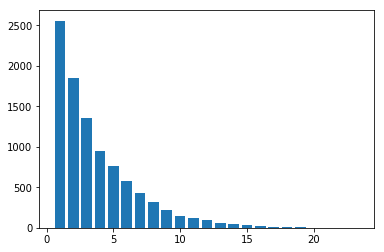

n genes (total) = 8417


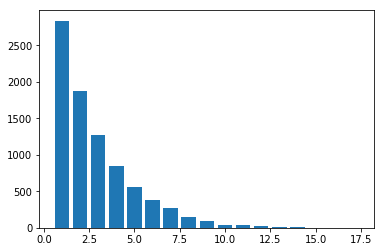

In [12]:
import matplotlib.pyplot as plt

import numpy as np

f = plt.figure()

t1 = df.query("num_sites >= 2").groupby("num_sites").agg({"gene" : "nunique"}).reset_index(drop=True)

print("n genes (total) = " + str(int(np.sum(t1['gene'].values))))

plt.bar(np.arange(len(t1)) + 1, t1['gene'].values)

plt.show()


f = plt.figure()

t1 = df.query("num_sites_pas_4 >= 2").groupby("num_sites_pas_4").agg({"gene" : "nunique"}).reset_index(drop=True)

print("n genes (total) = " + str(int(np.sum(t1['gene'].values))))

plt.bar(np.arange(len(t1)) + 1, t1['gene'].values)

plt.show()


f = plt.figure()

t1 = df.query("num_sites_pas_3 >= 2").groupby("num_sites_pas_3").agg({"gene" : "nunique"}).reset_index(drop=True)

print("n genes (total) = " + str(int(np.sum(t1['gene'].values))))

plt.bar(np.arange(len(t1)) + 1, t1['gene'].values)

plt.show()


f = plt.figure()

t1 = df.query("num_sites_pas_2 >= 2").groupby("num_sites_pas_2").agg({"gene" : "nunique"}).reset_index(drop=True)

print("n genes (total) = " + str(int(np.sum(t1['gene'].values))))

plt.bar(np.arange(len(t1)) + 1, t1['gene'].values)

plt.show()


f = plt.figure()

t1 = df.query("num_sites_pas_1 >= 2").groupby("num_sites_pas_1").agg({"gene" : "nunique"}).reset_index(drop=True)

print("n genes (total) = " + str(int(np.sum(t1['gene'].values))))

plt.bar(np.arange(len(t1)) + 1, t1['gene'].values)

plt.show()


In [8]:
#Process features

def _one_hot_encode_inplace(seq, x, i, k) :
    for j in range(len(seq)) :
        if seq[j] == 'A' :
            x[i, k, j, 0] = 1.
        elif seq[j] == 'C' :
            x[i, k, j, 1] = 1.
        elif seq[j] == 'G' :
            x[i, k, j, 2] = 1.
        elif seq[j] == 'T' :
            x[i, k, j, 3] = 1.
    return
    
    
min_pas_level = 3

max_num_sites = 30

df_sel = df.query("num_sites_pas_" + str(min_pas_level) + " >= 2 and num_sites_pas_" + str(min_pas_level) + " <= 30 and sitenum_pas_" + str(min_pas_level) + " != -1").copy().reset_index(drop=True)

genes = df_sel['gene'].unique()
gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes)}

cell_types = np.array(['rpm'], dtype=np.object)

cell_type_dict = {cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)}

x = np.zeros((genes.shape[0], max_num_sites, 205, 4))

m = np.zeros((genes.shape[0], max_num_sites))

l = np.zeros((genes.shape[0], max_num_sites))

prev_pos_dict = {}

c = np.zeros((genes.shape[0], max_num_sites, cell_types.shape[0]))

gene_df_dict = {}
gene_df_dict['gene'] = ['N/A'] * genes.shape[0]
gene_df_dict['strand'] = ['N/A'] * genes.shape[0]
gene_df_dict['chrom'] = ['N/A'] * genes.shape[0]

gene_df_cols = ['gene', 'strand', 'chrom']

for k in range(max_num_sites) :
    
    gene_df_dict['gene_id' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    gene_df_dict['site_type' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    gene_df_dict['pas' + "_" + str(k)] = [-1] * genes.shape[0]
    gene_df_dict['wide_seq_ext' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    gene_df_dict['iso_seq' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    gene_df_dict['pas_exists' + "_" + str(k)] = [0] * genes.shape[0]
    gene_df_dict['dist' + "_" + str(k)] = [-1] * genes.shape[0]
    
    gene_df_dict['pas_pos' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    gene_df_dict['cut_mode' + "_" + str(k)] = ['N/A'] * genes.shape[0]
    
    gene_df_cols.extend([
        'gene_id' + "_" + str(k),
        'site_type' + "_" + str(k),
        'pas' + "_" + str(k),
        'wide_seq_ext' + "_" + str(k),
        'iso_seq' + "_" + str(k),
        'pas_exists' + "_" + str(k),
        'dist' + "_" + str(k),
        
        'pas_pos' + "_" + str(k),
        'cut_mode' + "_" + str(k),
    ])

for index, row in df_sel.iterrows() :
    gene = row['gene']
    gene_id = row['gene_id']
    
    strand = row['strand']
    chrom = row['chrom']
    
    i = gene_dict[gene]
    k = row["sitenum_pas_" + str(min_pas_level)] - 1
    
    if i % 1000 == 0 and k == 0 :
        print("Processing gene " + str(i) + "...")
    
    seq = row['wide_seq_ext'][175-70:175-70+205]
    
    _one_hot_encode_inplace(seq, x, i, k)
    
    m[i, k] = 1.
    
    if gene not in prev_pos_dict :
        l[i, k] = 0.
    else :
        l[i, k] = np.abs(row['cut_mode'] - prev_pos_dict[gene])
    
    gene_df_dict['gene'][i] = gene
    gene_df_dict['strand'][i] = strand
    gene_df_dict['chrom'][i] = chrom
    
    gene_df_dict['gene_id' + "_" + str(k)][i] = gene_id
    gene_df_dict['pas' + "_" + str(k)][i] = row['pas']
    gene_df_dict['site_type' + "_" + str(k)][i] = row['site_type']
    gene_df_dict['wide_seq_ext' + "_" + str(k)][i] = row['wide_seq_ext']
    gene_df_dict['iso_seq' + "_" + str(k)][i] = row['iso_seq']
    gene_df_dict['pas_exists' + "_" + str(k)][i] = int(m[i, k])
    gene_df_dict['dist' + "_" + str(k)][i] = l[i, k]
    
    gene_df_dict['pas_pos' + "_" + str(k)][i] = row['pas_pos']
    gene_df_dict['cut_mode' + "_" + str(k)][i] = row['cut_mode']
    
    prev_pos_dict[gene] = row['cut_mode']
    
    for cell_type_i in range(cell_types.shape[0]) :
        cell_type = cell_types[cell_type_i]
        
        c[i, k, cell_type_i] = row[cell_type]

gene_df = pd.DataFrame(gene_df_dict)
gene_df = gene_df[gene_df_cols]

print(len(gene_df))
print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))


Processing gene 0...
Processing gene 1000...
Processing gene 2000...
Processing gene 3000...
Processing gene 4000...
Processing gene 5000...
Processing gene 6000...
Processing gene 7000...
Processing gene 8000...
Processing gene 9000...
Processing gene 10000...
10415
x.shape = (10415, 30, 205, 4)
m.shape = (10415, 30)
l.shape = (10415, 30)
c.shape = (10415, 30, 1)


In [9]:

total_c = np.sum(c, axis=(1, 2))

x = x[total_c > 0, ...]
m = m[total_c > 0, :]
l = l[total_c > 0, :]
c = c[total_c > 0, ...]
gene_df = gene_df.iloc[np.nonzero(total_c > 0)[0]].copy().reset_index(drop=True)

print(len(gene_df))
print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))


10415
x.shape = (10415, 30, 205, 4)
m.shape = (10415, 30)
l.shape = (10415, 30)
c.shape = (10415, 30, 1)


In [10]:

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

s = np.array(np.sum(c, axis=1) > 0, dtype=np.float)


In [11]:

gene_df.to_csv("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms.csv", sep='\t')


In [12]:

#np.savez("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms.npz", x=x, m=m, l=l, c=c, y=y, s=s)

np.savez("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms_no_x.npz", m=m, l=l, c=c, y=y, s=s)


In [14]:

save_dict = np.load("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms_no_x.npz")
m, l, c, y, s = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']


In [15]:
l

array([[   0.,  956.,   44., ...,    0.,    0.,    0.],
       [   0.,   35.,  342., ...,    0.,    0.,    0.],
       [   0.,  459., 2756., ...,    0.,    0.,    0.],
       ...,
       [   0.,   68.,    0., ...,    0.,    0.,    0.],
       [   0.,   49.,  398., ...,    0.,    0.,    0.],
       [   0., 2244.,   25., ...,    0.,    0.,    0.]])

In [16]:
#Re-load dataframe and construct Saluki halflife score matrix

min_pas_level = 3

gene_df = pd.read_csv("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms.csv", sep='\t')

saluki_df = pd.read_csv("polyadb_processed_v3_utr3_isoforms_saluki_pred.csv", sep='\t')

saluki_dict = {}
for f in np.arange(10).tolist() :
    for c in np.arange(5).tolist() :
        for _, row in saluki_df.iterrows() :
            saluki_dict[row['gene_id'] + "_f" + str(f) + "_c" + str(c)] = row['isoform_hl_f' + str(f) + '_c' + str(c)]


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (202,203,205,206,211,212,214,215,220,221,223,224,229,230,232,233,238,239,241,242,247,248,250,251,256,257,259,260,265,266,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:

max_num_sites = 30

fs = np.arange(10).tolist()
cs = np.arange(5).tolist()

hl = np.zeros((len(gene_df), max_num_sites, len(fs) * len(cs)))
hl_m = np.zeros((len(gene_df), max_num_sites))

k = 0
for f in fs :
    for c in cs :
        i = 0
        for _, row in gene_df.iterrows() :

            for j in range(max_num_sites) :

                if row['pas_exists_' + str(j)] == 1 and row['gene_id_' + str(j)] + "_f" + str(f) + "_c" + str(c) in saluki_dict :
                    hl[i, j, k] = saluki_dict[row['gene_id_' + str(j)] + "_f" + str(f) + "_c" + str(c)]
                    hl_m[i, j] = 1.

            i += 1
        
        k += 1


In [18]:

np.savez("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms_saluki.npz", hl=hl, hl_m=hl_m)


In [3]:
min_pas_level = 3

col_dict = {'Unnamed: 0' : 'str', 'gene_id' : 'str'}
for f in np.arange(10).tolist() :
    for c in np.arange(5).tolist() :
        for feature_ix in range(64) :
            col_dict['isoform_hl_f' + str(f) + '_c' + str(c) + "_feature_" + str(feature_ix)] = 'float16'

gene_df = pd.read_csv("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms.csv", sep='\t')

saluki_df = pd.read_csv("polyadb_processed_v3_utr3_isoforms_saluki_pred_dense_full.csv", sep='\t', dtype=col_dict)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (202,203,205,206,211,212,214,215,220,221,223,224,229,230,232,233,238,239,241,242,247,248,250,251,256,257,259,260,265,266,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Re-load dataframe and construct Saluki halflife score matrix (dense features)

min_pas_level = 3

gene_df = pd.read_csv("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms.csv", sep='\t')

saluki_df = pd.read_csv("polyadb_processed_v3_utr3_isoforms_saluki_pred_dense_full.csv", sep='\t')

saluki_dict = {}
for f in np.arange(10).tolist() :
    print("f = " + str(f))
    for c in np.arange(5).tolist() :
        for _, row in saluki_df.iterrows() :
            for feature_ix in range(64) :
                saluki_dict[row['gene_id'] + "_f" + str(f) + "_c" + str(c) + "_feature_" + str(feature_ix)] = row['isoform_hl_f' + str(f) + '_c' + str(c) + "_feature_" + str(feature_ix)]


f = 0


In [ ]:

gene_df = None
saluki_df = None


In [ ]:

max_num_sites = 30

hl = np.zeros((len(gene_df), max_num_sites, 50, 64), dtype=np.float16)
hl_m = np.zeros((len(gene_df), max_num_sites), dtype=np.float16)

k = 0
for f in np.arange(10).tolist() :
    for c in np.arange(5).tolist() :
        print("k = " + str(k))
        
        i = 0
        for _, row in gene_df.iterrows() :
            for j in range(max_num_sites) :
                for feature_ix in range(64) :
                    if row['pas_exists_' + str(j)] == 1 and row['gene_id_' + str(j)] + "_f" + str(f) + "_c" + str(c) + "_feature_" + str(feature_ix) in saluki_dict :
                        hl[i, j, k, feature_ix] = saluki_dict[row['gene_id_' + str(j)] + "_f" + str(f) + "_c" + str(c) + "_feature_" + str(feature_ix)]
                        hl_m[i, j] = 1.

            i += 1
        
        k += 1


In [ ]:

np.savez("polyadb_features_pas_" + str(min_pas_level) + "_utr3_isoforms_saluki_dense_full.npz", hl=hl, hl_m=hl_m)
